# ML2: notebook to decompose and fit energies of gamma-Ga2O3

- takes a set of input structures for 1x1x3 supercells and their DFT-calculated energies and fits a simple machine learning model
- specifically, takes 884 structures, including those used to fit ML1 and the extra 45 structures which were predicted to be low energy by ML1
- also writes the model and associated environments to disk for reuse

System Specific Information

In [1]:
# number of distinct Ga sites
nGa_sites = 4

# atomic species present in the system
species_list = ['Ga', 'O']

# number of structures
nstrucs = 884

# directory where structures are found
struc_dir = 'unrelaxed_structures'

# cut-off radii for the model and associated label
rcut = {'Ga-Ga': 4.3, 'Ga-O': 4.8, 'O-O': 0.0}
rcut_label = 'GaGa'+str(rcut['Ga-Ga'])+'_GaO'+str(rcut['Ga-O'])+'_OO'+str(rcut['O-O'])

Read in structures from xyz files

In [2]:
import os
from os import path
import ga2o3

# list of all structures
structure_list = []

for istruc in range(nstrucs):   
    # start numbering from 1, not 0
    name = 'Ga2O3_'+str(istruc + 1)
    filename = struc_dir+'/'name+'.xyz'
    
    if path.exists(filename):
        structure = ga2o3.read_ga2o3(filename)
        print('Structure found for ',name, ': ',structure['nsite'], '-site structure with occupancies ', end = '')
        for i in range(nGa_sites):
            print ('{0:.3f}'.format(structure['occupancies'][i]), ' ', end = '')
        print('')
    else:
        print('Error, missing filename ', name)
        assert False

    structure_list.append(structure)

Structure found for  Ga2O3_1 :  2 -site structure with occupancies 1.000  0.833  0.000  0.000  
Structure found for  Ga2O3_2 :  4 -site structure with occupancies 0.833  0.854  0.014  0.021  
Structure found for  Ga2O3_3 :  3 -site structure with occupancies 0.917  0.833  0.014  0.000  
Structure found for  Ga2O3_4 :  4 -site structure with occupancies 0.625  0.896  0.021  0.062  
Structure found for  Ga2O3_5 :  4 -site structure with occupancies 0.750  0.854  0.028  0.021  
Structure found for  Ga2O3_6 :  4 -site structure with occupancies 0.792  0.833  0.028  0.021  
Structure found for  Ga2O3_7 :  4 -site structure with occupancies 0.667  0.938  0.007  0.042  
Structure found for  Ga2O3_8 :  3 -site structure with occupancies 0.792  0.812  0.042  0.000  
Structure found for  Ga2O3_9 :  2 -site structure with occupancies 0.958  0.854  0.000  0.000  
Structure found for  Ga2O3_10 :  4 -site structure with occupancies 0.750  0.854  0.021  0.042  
Structure found for  Ga2O3_11 :  4 -sit

Find environments of nearest neighbours for each atom

In [3]:
import model_setup

# environments for all atoms in all structures
all_environments = []

# directory where environments should be stored
directory = 'environments'
if not os.path.exists(directory):
    os.makedirs(directory)
    
for istruc in range(nstrucs):   
    neighbour_file = directory+'/struc'+str(istruc + 1)+'_neighbours.txt'

    # the environments associated with each atom in this structure
    environments = model_setup.find_neighbours(structure_list[istruc]['posinp'], rcut, 
                                               alat=structure_list[istruc]['alat'],
                                               read=True, write=True, filename=neighbour_file)    
        
    all_environments.append(environments)
    
print('Finished identifying neighbours for ', nstrucs, ' structures')

Finished identifying neighbours for  884  structures


Identify distinct environments across all structures

In [9]:
# list of distinct reference environments
reference_environments = []

# decomposition of each structure into the number of instances of each reference environment
all_decompositions = []

for istruc in range(nstrucs):
    environments = all_environments[istruc]

    # full set of reference structures - will be overwritten for each structure as we only need the final list
    ref_file = directory+'/reference_environments.txt'
    
    # decomposition for each structure
    decomp_file = directory+'/struc'+str(istruc + 1)+'_decomposition.txt'
            
    decomposition, reference_environments, ordered_decomposition = \
                 model_setup.deconstruct_structure(environments, reference_environments,
                                                   species_list, separate_species=True,
                                                   reference_file=ref_file, decomposition_file=decomp_file,
                                                   read=True, write=True)
            
    print('Environments in ',structure_list[istruc]['nsite'],\
          '-site structure', istruc + 1, ' for rcut =', rcut_label,\
          ' =',decomposition['num_environments'], ', total across structures = ',len(reference_environments))
                
    all_decompositions.append(decomposition)

Environments in  2 -site structure 1  for rcut = GaGa4.3_GaO4.8_OO0.0  = 11 , total across structures =  11
Environments in  4 -site structure 2  for rcut = GaGa4.3_GaO4.8_OO0.0  = 19 , total across structures =  19
Environments in  3 -site structure 3  for rcut = GaGa4.3_GaO4.8_OO0.0  = 17 , total across structures =  20
Environments in  4 -site structure 4  for rcut = GaGa4.3_GaO4.8_OO0.0  = 18 , total across structures =  20
Environments in  4 -site structure 5  for rcut = GaGa4.3_GaO4.8_OO0.0  = 18 , total across structures =  21
Environments in  4 -site structure 6  for rcut = GaGa4.3_GaO4.8_OO0.0  = 18 , total across structures =  22
Environments in  4 -site structure 7  for rcut = GaGa4.3_GaO4.8_OO0.0  = 18 , total across structures =  23
Environments in  3 -site structure 8  for rcut = GaGa4.3_GaO4.8_OO0.0  = 18 , total across structures =  23
Environments in  2 -site structure 9  for rcut = GaGa4.3_GaO4.8_OO0.0  = 15 , total across structures =  23
Environments in  4 -site str

Read in DFT energies

In [12]:
energy_filename = struc_dir+'/energies.dat'
dft_energies = model_setup.read_dft_energies(energy_filename, nstrucs)
    
# get lowest energy from initial 839 structures as a reference
ref_energy = min(dft_energies[:839])

Reading energies from unrelaxed_structures/energies.dat
-292.710546539
839


Fit the model

In [6]:
import model_fit
import random
import numpy as np

# minimum size of training and validation sets
ntrain_initial = 25

# size of validation set
nvalid = int(nstrucs / 3.0)

# interval to increase training set by
dn = 5

# regularization parameter for fitting
alpha = 0.5

# randomize the data - calling in such a way that it gives the same result as python2
structure_order = list(range(nstrucs))
random.seed(7, version=1)
random.shuffle(structure_order, random.random)  

# reorder the shuffled structures to ensure that those with new environments appear first
structure_order = model_fit.reorder_structures(structure_order, all_decompositions)

# split into training and validation data
training_set, validation_set = model_fit.split_data(nvalid, dft_energies, structure_order,
                                                    all_decompositions, len(reference_environments))

if len(validation_set['structures']) != nvalid:
    print('Warning, validation set size was modified from ', nvalid, ' to ', len(validation_set['structures']))

# start by including all the structures in the training set, then gradually reduce so we can assess convergence
ntrain = len(training_set['structures'])

model_data = []

while True:
    # fit data for the different training set sizes
    model_data.append(model_fit.fit_model(ntrain, training_set, validation_set, alpha=alpha))
 
    ntrain -= dn
    
    if ntrain < ntrain_initial:
        break

# index associated with the largest training set size
ind = 0 
print('MAE: '+'{0:.2f}'.format(1000.0 * model_data[ind]['MAE']), '(meV/atom)')

# write model to file 
fit_filename = directory+'/model_ml2.dat'
model_fit.write_model(fit_filename, model_data[ind])

MAE: 7.55 (meV/atom)


Plot model correlation

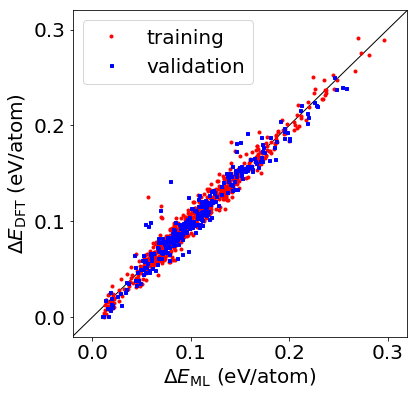

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

es = np.arange(-1000.0, 1000.0, 0.1)
ax.plot(es, es, marker='', color='k', ls='-', lw=1)

for d,data_set in enumerate(['training_set', 'validation_set']):
    for i in range(len(model_data[ind][data_set]['dft_energies'])):
        
        # plot training and validation sets separately
        if d == 0:
            color = 'red'
            marker = 'o'
        else:
            color = 'blue'
            marker = 's'
        
        if i == 0 and d == 0:
            label = 'training'
        elif i == 0:
            label = 'validation'
        else:
            label = ''
        
        ax.plot(model_data[ind][data_set]['ml_energies'][i] - ref_energy, 
                model_data[ind][data_set]['dft_energies'][i] - ref_energy,
                color=color, marker=marker, ms=3, ls='', label=label)
        
emin=-0.02
emax=0.32
de = 0.1
ax.set_xlim(emin, emax)
ax.set_ylim(emin, emax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(de))
ax.yaxis.set_major_locator(ticker.MultipleLocator(de))
ax.set_xlabel('$\Delta E_{\mathrm{ML}}$ (eV/atom)')
ax.set_ylabel('$\Delta E_{\mathrm{DFT}}$ (eV/atom)')
ax.legend(loc='upper left')
        
plt.show()

Plot model convergence with respect to training set size

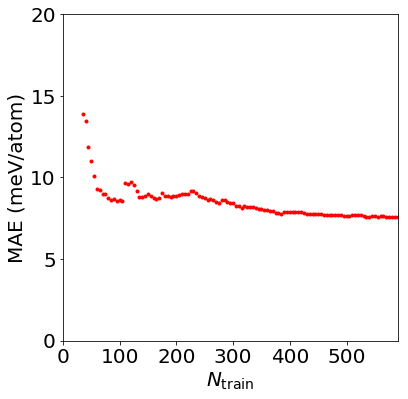

In [8]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ntrains = [model_data[i]['ntrain'] for i in range(len(model_data))]
maes = [1000.0 * model_data[i]['MAE'] for i in range(len(model_data))]

ax.plot(ntrains, maes, color='red', marker='o', ms=3, ls='')

ax.set_xlim(0, model_data[ind]['ntrain'])
ax.set_ylim(0, 20)
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('$N_{\mathrm{train}}$')
ax.set_ylabel('MAE (meV/atom)')
        
plt.show()